In [235]:
import numpy as np
import scipy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

TITANIC_PATH = "datasets/Titanic/train.csv"


import warnings
warnings.filterwarnings('ignore')

def load_titanic_data(titanic_path = TITANIC_PATH):
    return pd.read_csv(TITANIC_PATH)

tit_data = load_titanic_data()
#print(tit_data.info)

#separating labels and training, randomizing the sequence of the samples
tit_data2 = tit_data.copy()
X_train_df = (tit_data2.drop(["Survived", "Name"], axis = 1))
X_train = X_train_df.values
y_train = (tit_data["Survived"]).values
shuffle_index = np.random.permutation(891)    #0 to 890
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


cols = X_train_df.columns
X_train = pd.DataFrame(X_train, columns = cols)


#making dummy variables for the string features
string_feats = X_train.iloc[:, [2, 9]]
gd = pd.get_dummies(string_feats, prefix = ['Sex', 'Embarked'])


#joining dummies and originals
X_train.drop(["Sex", "Embarked", "Cabin", "Ticket"], axis = 1, inplace = True)
X_train = pd.concat([X_train, gd], axis = 1 )


#putting median age in the Nans
from sklearn.impute import SimpleImputer
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = imp_med.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imp, columns = X_train.columns)
print(X_train.columns)

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [236]:
#Removing outliers

from collections import Counter
print("training set before removing outliers ", X_train.shape)

#removing otliers from the data
def remove_outlier_rows(f_name_array, given_number):
    outlier_cols = []
    
    for one_col in f_name_array:
        P1 = np.percentile(X_train[one_col], 25)
        P2 = np.percentile(X_train[one_col], 75)
        IQR = P2 - P1
        outlier_step = 1.5 * IQR
       
        indices_outlier_rows = X_train[(X_train[one_col] > P2 + outlier_step) | (X_train[one_col] < P1 - outlier_step)].index
        #print(X_train[(X_train[one_col] > P2 + IQR) | (X_train[one_col] < P1 - IQR)])
        outlier_cols.extend(indices_outlier_rows)
       
    check = Counter(outlier_cols)
    
    rows_to_remove = [k for k,v in check.items() if v > given_number]
    #print((rows_to_remove))

    X_train.drop(rows_to_remove, inplace = True)
    return rows_to_remove

rows_removed = remove_outlier_rows(["Age", "Parch", "SibSp", "Fare"], 2)
y_train = np.delete(y_train, rows_removed, 0)
print("training set shape ",X_train.shape)
print("training labels shape ", y_train.shape) 



training set before removing outliers  (891, 11)
training set shape  (866, 11)
training labels shape  (866,)


In [117]:

# X_train["fam_size"] = X_train["SibSp"] + X_train["Parch"]
# X_train.drop(["PassengerId", "SibSp", "Parch"], axis = 1, inplace = True)


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

sgd_clf = SGDClassifier()
sgd_scrs = cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
print("(SGD non scaled)", sgd_scrs)

#using standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
sgd_scrs_scaled = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
print("(SGD scaled)", sgd_scrs_scaled)

#using randomforestclassifier unscaled
forest_clf = RandomForestClassifier(random_state = 42)
frst_scrs = cross_val_score(forest_clf, X_train, y_train, cv = 3, scoring = "accuracy")
print("(Random Forest unscaled)", frst_scrs)

#using randomforestclassifier scaled
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
frst_scrs = cross_val_score(forest_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
print("(Random Forest scaled)", frst_scrs)


(SGD non scaled) [0.61937716 0.63321799 0.42013889]
(SGD scaled) [0.70588235 0.75778547 0.75694444]
(Random Forest unscaled) [0.80622837 0.79584775 0.82291667]
(Random Forest scaled) [0.80276817 0.78200692 0.82986111]


<BarContainer object of 3 artists>

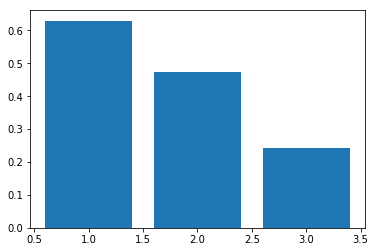

In [122]:
survivability = tit_data.groupby(["Pclass"])["Survived"].mean()
Pclass_values = tit_data.groupby(["Pclass"]).groups.keys()
# print(a)
# at = [len(v) for k,v in te.groups.items()]
# at
plt.bar(Pclass_values, survivability)


In [128]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
params = {
    'n_estimators': randint(100,500),
     'max_features': randint(1, 11)
}
 
newgridsearch = RandomizedSearchCV(forest_clf, param_distributions = params, n_iter=10, cv = 5, scoring='accuracy')
r_grid_search = newgridsearch.fit(X_train, y_train)
r_cv = r_grid_search.cv_results_

for score, params in zip(r_cv["mean_test_score"], r_cv["params"]):
    print(score, params)

0.8163972286374134 {'max_features': 2, 'n_estimators': 356}
0.8163972286374134 {'max_features': 10, 'n_estimators': 477}
0.8210161662817552 {'max_features': 3, 'n_estimators': 477}
0.8163972286374134 {'max_features': 10, 'n_estimators': 312}
0.8290993071593533 {'max_features': 6, 'n_estimators': 228}
0.8267898383371824 {'max_features': 6, 'n_estimators': 263}
0.8175519630484989 {'max_features': 2, 'n_estimators': 372}
0.812933025404157 {'max_features': 1, 'n_estimators': 349}
0.8210161662817552 {'max_features': 2, 'n_estimators': 407}
0.8175519630484989 {'max_features': 9, 'n_estimators': 308}


In [237]:
#a = tit_data.Ticket.str.split(" ", expand = True)[0]
#appending an 'X' for tickets with no prefix
tit_data['Ticket'] = tit_data['Ticket'].apply(lambda x: x.replace(' ','', 1) if len(x.split()) == 3 else x)
tit_data['Ticket'] = tit_data['Ticket'].apply(lambda x: ('X ' + x ) if len(x.split()) == 1 else x)

tit_data[['TktPre', 'TktNum']] = tit_data.Ticket.str.split(' ', expand = True)


In [238]:
a = lambda x: len(x.Ticket.split())
a2 = tit_data.apply(a, axis=1)
a2[a2 != 2]


Series([], dtype: int64)

In [227]:
tit_data.Ticket[473]

'SC/AH Basle 541'

In [ ]:
'STON/O 2. 3101280'

In [233]:
'www.example.com.nomi'.strip('omw')


'.example.com.nomi'